# SerPyShock simplified notebook

In [1]:
from matplotlib import pyplot as plt
import datetime as dt
import numpy as np
import pandas as pd
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.dates as mdates
import speasy as spz
from SerPyShock import SerPyShock
import warnings
warnings.filterwarnings("ignore", message="astropy did not recognize units*")

In [2]:
path = 'data/'  # Directory for the downloaded data in this project
plt.rcParams.update({'font.size': 12})  # increase font size for matplotlib

### Set plotting window

In [3]:
#Set window for data loading
start_time = pd.to_datetime('2021-11-03 13:50:00')
end_time = pd.to_datetime('2021-11-03 14:20:00')

### Download magnetic field and plasma data

In [4]:
amda_tree = spz.inventories.data_tree.amda
extend_min = dt.timedelta(minutes=60)
# Download magnetic field data for the zoomed-in interval
solo_mag = spz.get_data(amda_tree.Parameters.SolarOrbiter.MAG.L2.so_mag_rtnhr.solo_b_rtn_hr, start_time-extend_min, end_time+extend_min)
df_mag = solo_mag.to_dataframe()
df_mag.rename(columns={"solo_b_rtn_hr[0]": "B_RTN_0", "solo_b_rtn_hr[1]": "B_RTN_1", "solo_b_rtn_hr[2]": "B_RTN_2"}, inplace=True)
df_mag["B"] = np.linalg.norm(df_mag[["B_RTN_0", "B_RTN_1", "B_RTN_2"]], axis=1)

# Download SWA data
solo_swa = spz.get_data(amda_tree.Parameters.SolarOrbiter.PAS.L2.so_pas_momgr1.pas_momgr1_v_rtn, start_time-extend_min, end_time+extend_min)
df_swa = solo_swa.to_dataframe()
df_swa.rename(columns={"pas_momgr1_v_rtn[0]": "V_RTN_0", "pas_momgr1_v_rtn[1]": "V_RTN_1", "pas_momgr1_v_rtn[2]": "V_RTN_2"}, inplace=True)
df_swa["V"] = np.linalg.norm(df_swa[["V_RTN_0", "V_RTN_1", "V_RTN_2"]], axis=1)

solo_swa = spz.get_data(amda_tree.Parameters.SolarOrbiter.PAS.L2.so_pas_momgr1.pas_momgr_n, start_time-extend_min, end_time+extend_min)
df_swa["N"] = solo_swa.to_dataframe()

solo_swa = spz.get_data(amda_tree.Parameters.SolarOrbiter.PAS.L2.so_pas_momgr1.pas_momgr_tav, start_time-extend_min, end_time+extend_min)
df_swa["T"] = solo_swa.to_dataframe()

### Select shock time and set up parameters for SerPyShock estimation
Just for your info, remember that the ipshocks.fi catalogue uses windows of 8 minutes upstream and 8 minutes downstream of the shock, and they exclude 1 minute upstream and 2 minutes downstream of the shock

In [5]:
#Select the shock time
shock_time = pd.to_datetime('2021-11-03 14:04:20')
#Select the largest and smallest upstream windows
start_time_up  = shock_time  - dt.timedelta(minutes = 9) #Start time of the largest upstream window
end_time_up = shock_time  - dt.timedelta(minutes = 1)    #End time of the largest upstream window
min_dur_up = dt.timedelta(minutes=2) #Duration of the smallest upstream window
#Select the largest and smallest downstream windows 
start_time_down  = shock_time  + dt.timedelta(minutes = 2) #Start time of the downstream window
end_time_down = shock_time  + dt.timedelta(minutes = 10)   #End time of the largest downstream window
min_dur_down = dt.timedelta(minutes=2) #Duration of the smallest downstream window
#Select the cadence by which the window lengths are increased (should be larger than the data cadence)
cadence =  dt.timedelta(seconds=20)

In [6]:
#Calculate averaging window parameters (start times, end times, and durations)
stut_min, stut_max, endt_min, endt_max, max_dur_up, max_dur_down = SerPyShock.window_parameters(start_time_up,end_time_up,start_time_down,end_time_down,min_dur_up,min_dur_down,cadence)

### Generate overview plot of event with smallest and largest upstream/downstream windows

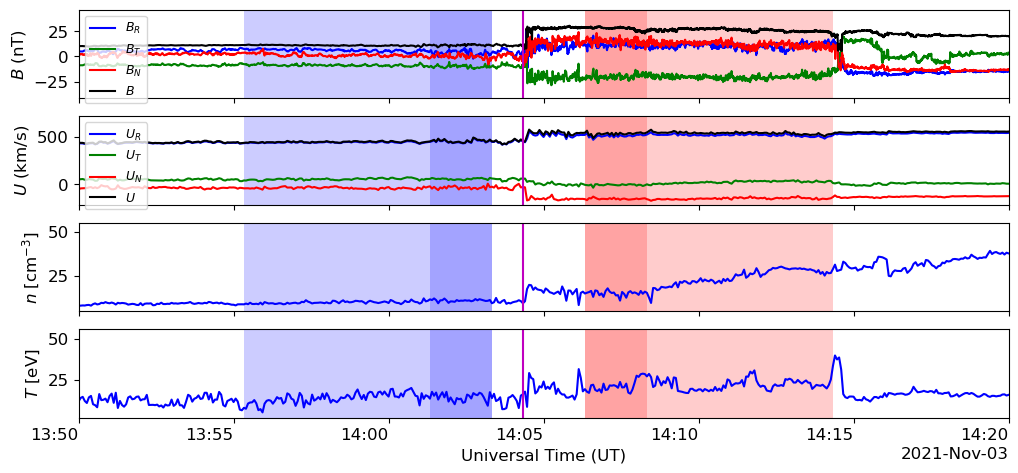

In [7]:
fsax = 12 #fontsize ax 
#Determine the limits of the upstream and downstream windows, smallest and largest

fig = plt.figure(figsize = (12,6))
gs = fig.add_gridspec(4,1)

ax1 = fig.add_subplot(gs[0, 0])
df_mag[["B_RTN_0","B_RTN_1","B_RTN_2","B"]].plot(ax=ax1,color=["blue","green","red","black"])
ax1.set_ylabel("$B$ (nT)",fontsize=fsax)
ax1.legend(loc='upper left', fontsize=9,labels=["$B_R$","$B_T$","$B_N$","$B$"])

ax2 = fig.add_subplot(gs[1, 0])
df_swa[["V_RTN_0","V_RTN_1","V_RTN_2","V"]].plot(ax=ax2,color=["blue","green","red","black"])
ax2.set_ylabel("$U$ (km/s)", fontsize=fsax)
ax2.legend(loc='upper left', fontsize=9,labels=["$U_R$","$U_T$","$U_N$","$U$"])

ax3 = fig.add_subplot(gs[2, 0])
df_swa["N"].plot(ax=ax3,color="b")
ax3.set_ylabel('$n$ [cm$^{-3}$]',fontsize=fsax)

ax4 = fig.add_subplot(gs[3, 0])
df_swa["T"].plot(ax=ax4,color="b",rot=0)
ax4.set_ylabel('$T$ [eV]',fontsize=fsax)
ax4.set_xlabel("Universal Time (UT)")
locator = mdates.AutoDateLocator()
ax4.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))

for ax in [ax1,ax2,ax3,ax4]:
    ax.axvline(x=shock_time,color='m')
    ax.axvspan(stut_min,end_time_up, facecolor = 'b', alpha = 0.2)
    ax.axvspan(stut_max,end_time_up, facecolor = 'b', alpha = 0.2)
    ax.axvspan(start_time_down,endt_min, facecolor = 'r', alpha = 0.2)
    ax.axvspan(start_time_down,endt_max, facecolor = 'r', alpha = 0.2)
    ax.set_xlim(start_time,end_time)
    if ax!=ax4:
        ax.set_xticklabels('')
        ax.set_xlabel('')
fig.savefig('Nov3_overview.png',format='png',dpi=300, bbox_inches = 'tight',facecolor='white')

In [8]:
#Preparation of the input parameters for SerPyShock
B = df_mag[["B_RTN_0","B_RTN_1","B_RTN_2"]].values
B_times = df_mag.index
V = df_swa[["V_RTN_0","V_RTN_1","V_RTN_2"]].values
rho = df_swa["N"].values
Tp = df_swa["T"].values
mom_times = df_swa.index
coord = "RTN"

### First SerPyShock run: shock normals and $\theta_{Bn}$, magnetic compression ratios $r_B$
This estimates the set of shock normals and relative $\theta_{Bn}$ with Magnetic Coplanarity and Mixed Mode methods MX1, MX2 and MX3. It builds also a distribution of magnetic compression ratios.

In [9]:
#Run SerPyShock systematic calculations
n, tbn, rB, ex = SerPyShock.MX_stats(B_times, B, mom_times, V, shock_time, end_time_up, start_time_down, min_dur_up, max_dur_up, min_dur_down, max_dur_down, cadence, coord)

### Histogram of $\theta_{Bn}$

In [10]:
#Colors
CB = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

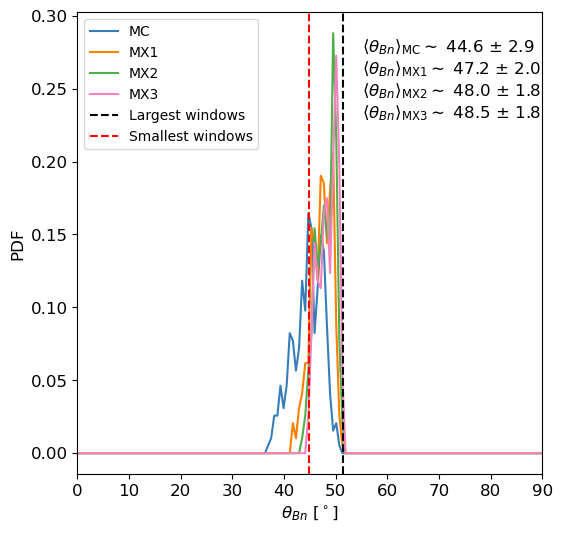

In [11]:
nbns = 150
hist1,bin_edges = np.histogram(tbn.MC, bins = nbns, range=(0,90), density=True)
hist2,bin_edges = np.histogram(tbn.MX1, bins = nbns, range=(0,90), density=True)
hist3,bin_edges = np.histogram(tbn.MX2, bins = nbns, range=(0,90), density=True)
hist4,bin_edges = np.histogram(tbn.MX3, bins = nbns, range=(0,90), density=True)
bin_centers = bin_edges[0:-1] + (bin_edges[1:]-bin_edges[0:-1])/2

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot()
ax.plot(bin_centers,hist1, color = CB[0], label = 'MC')
ax.plot(bin_centers,hist2, color = CB[1], label = 'MX1')
ax.plot(bin_centers,hist3, color = CB[2], label = 'MX2')
ax.plot(bin_centers,hist4, color = CB[3], label = 'MX3')
ax.axvline(x=ex.tbn_luld,linestyle = '--',color='black', label = 'Largest windows')
ax.axvline(x=ex.tbn_susd,linestyle = '--',color='red',   label = 'Smallest windows')
ax.set_xlabel(r'$\theta_{Bn}$ $[^\circ]$',fontsize=fsax)
ax.set_ylabel(r'PDF',fontsize=fsax)
ax.legend(fontsize=10, loc='upper left')

values = [tbn.MC,tbn.MX1,tbn.MX2,tbn.MX3]
labels = ["MC","MX1","MX2","MX3"]
i = 0
for value,label in zip(values,labels):
    avg = np.mean(value)
    std = np.std(value)
    st = '$\langle \\theta_{Bn} \\rangle_{\mathrm{%s}} \sim $ %0.1f $\pm $ %0.1f' %(label,avg,std)
    plt.text(55,0.275-i*0.015,st,fontsize=12)
    i += 1

ax.set_xlim(0,90)
fig.savefig('Nov3_tbn.png',format='png',dpi=300, bbox_inches = 'tight',facecolor='white')

### Magnetic compression ratio diagnostic and histogram

In [12]:
#Edit if you like
nbns = 40 # Number of bins for the histogram
rbmin = 0 # Minimum compression ratio you want to sample
rbmax = 6 # Maximum compression ratio you want to sample

(0.0, 6.0)

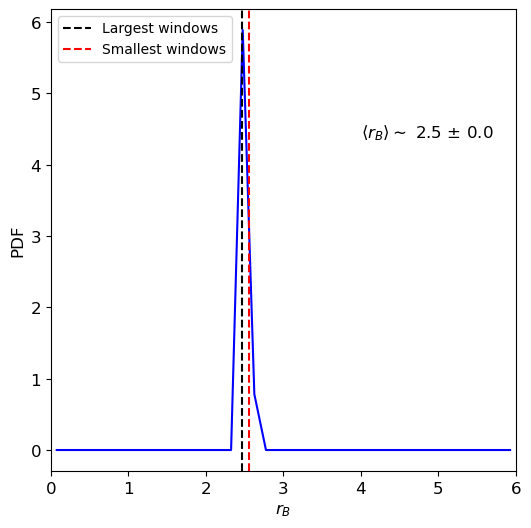

In [13]:
hist_rB,bin_edges = np.histogram(rB, bins = nbns, range=(rbmin,rbmax), density=True)
bin_centers = bin_edges[0:-1] + (bin_edges[1:]-bin_edges[0:-1])/2

fig = plt.figure(figsize = (6,6))
ax5 = fig.add_subplot()
ax5.plot(bin_centers,hist_rB, color = 'b')

ax5.axvline(x=ex.rB_luld,linestyle = '--',color='black', label = 'Largest windows')
ax5.axvline(x=ex.rB_susd,linestyle = '--',color='red',   label = 'Smallest windows')
ax5.set_xlabel(r'$r_B$',fontsize=fsax)
ax5.set_ylabel(r'PDF',fontsize=fsax)
ax5.legend(fontsize=10, loc='upper left')
avg = np.mean(rB)
std = np.std(rB)
st = '$\langle r_B \\rangle \sim $ %0.1f $\pm $ %0.1f' %(avg,std)
plt.text(rbmax - 2, np.max(hist_rB)-1.5, st,fontsize=12)
ax5.set_xlim(rbmin, rbmax)
#fig.savefig('Nov3_rB.png',format='png',dpi=300, bbox_inches = 'tight',facecolor='white')

### Gas compression ratio diagnotic and histogram

In [14]:
rG, ex_rG = SerPyShock.rgas_stats(mom_times, rho, shock_time, end_time_up, start_time_down, min_dur_up, max_dur_up, min_dur_down, max_dur_down, cadence)

In [15]:
#Edit if you like
nbns = 40 # Number of bins for the histogram
rgmin = 0 # Minimum compression ratio you want to sample
rgmax = 6 # Maximum compression ratio you want to sample

(0.0, 6.0)

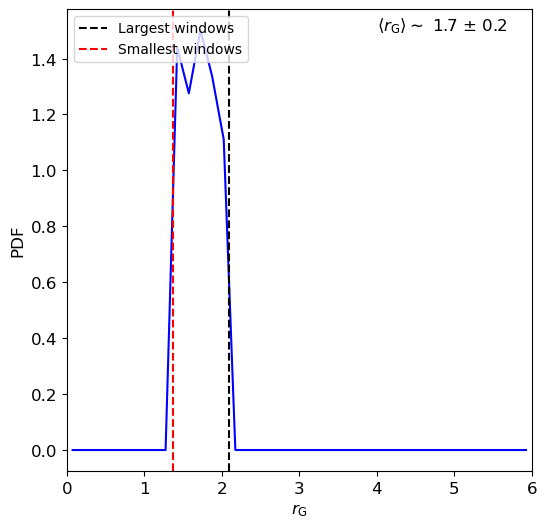

In [16]:
hist_rG,bin_edges = np.histogram(rG, bins = nbns, range=(rgmin,rgmax), density=True)
bin_centers = bin_edges[0:-1] + (bin_edges[1:]-bin_edges[0:-1])/2

fig = plt.figure(figsize = (6,6))
ax5 = fig.add_subplot()
ax5.plot(bin_centers,hist_rG, color = 'b')

ax5.axvline(x=ex_rG.r_max,linestyle = '--',color='black', label = 'Largest windows')
ax5.axvline(x=ex_rG.r_min,linestyle = '--',color='red',   label = 'Smallest windows')
ax5.set_xlabel(r'$r_\mathrm{G}$',fontsize=fsax)
ax5.set_ylabel(r'PDF',fontsize=fsax)
ax5.legend(fontsize=10, loc='upper left')
avg = np.mean(rG)
std = np.std(rG)
st = '$\langle r_\mathrm{G} \\rangle \sim $ %0.1f $\pm $ %0.1f' %(avg,std)
plt.text(rbmax - 2, np.max(hist_rG), st,fontsize=12)

ax5.set_xlim(rgmin, rgmax)
#fig.savefig('Nov3_rG.png',format='png',dpi=300, bbox_inches = 'tight',facecolor='white')

### Display average shock normals

In [17]:
print("Your average shock normals are:")
values = [n.MC,n.MX1,n.MX2,n.MX3]
labels = ["MC","MX1","MX2","MX3"]
i = 0
for value,label in zip(values,labels):
    avg = np.mean(value, axis=0)
    avg = avg/np.linalg.norm(avg) # normalise
    print( label + str(avg))
    i += 1

Your average shock normals are:
MC[ 0.2735401  -0.68716541 -0.67303753]
MX1[ 0.51748265 -0.5334461  -0.66906425]
MX2[ 0.55060468 -0.50615784 -0.66380624]
MX3[ 0.56633333 -0.49259149 -0.66077241]


## Shock speed estimation using mass flux conservation
Run SerPyShock to get a distribution of shock speeds, computed in the spacecraft rest frame and along the shock normal. Here we use the normals obtained in the previous SerPyShock run using MC, MX1, MX2 and MX3.

In [18]:
vsh, exv = SerPyShock.Vsh_stats2(n, mom_times, V, rho, shock_time,end_time_up, start_time_down, min_dur_up, max_dur_up, min_dur_down, max_dur_down, cadence)

In [36]:
#Edit if you like
nbns = 100 # Number of bins for the histogram
bins = np.linspace(0,1000,nbns)

(200.0, 1000.0)

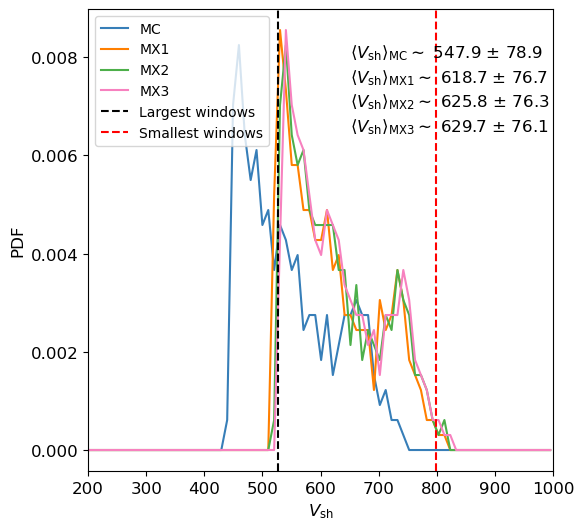

In [40]:
hist1,bin_edges = np.histogram(vsh.MC, bins = bins, density=True)
hist2,bin_edges = np.histogram(vsh.MX1, bins = bins, density=True)
hist3,bin_edges = np.histogram(vsh.MX2, bins = bins, density=True)
hist4,bin_edges = np.histogram(vsh.MX3, bins = bins, density=True)
bin_centers = bin_edges[0:-1] + (bin_edges[1:]-bin_edges[0:-1])/2

fig = plt.figure(figsize = (6,6))
ax5 = fig.add_subplot()
CB = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
ax5.plot(bin_centers,hist1, color = CB[0], label = 'MC')
ax5.plot(bin_centers,hist2, color = CB[1], label = 'MX1')
ax5.plot(bin_centers,hist3, color = CB[2], label = 'MX2')
ax5.plot(bin_centers,hist4, color = CB[3], label = 'MX3')

ax5.axvline(x=exv.vshmax,linestyle = '--',color='black', label = 'Largest windows')
ax5.axvline(x=exv.vshmin,linestyle = '--',color='red',   label = 'Smallest windows')
ax5.set_xlabel(r'$V_\mathrm{sh}$',fontsize=fsax)
ax5.set_ylabel(r'PDF',fontsize=fsax)
ax5.legend(fontsize=10, loc='upper left')

values = [vsh.MC,vsh.MX1,vsh.MX2,vsh.MX3]
labels = ["MC","MX1","MX2","MX3"]
i = 0
for value,label in zip(values,labels):
    avg = np.mean(value)
    std = np.std(value)
    st = '$\langle V_\\mathrm{sh} \\rangle_{\mathrm{%s}} \sim $ %0.1f $\pm $ %0.1f' %(label,avg,std)
    plt.text(650,0.008-i*0.0005,st,fontsize=12)
    i += 1
ax5.set_xlim(200,1000)
#fig.savefig('Nov3_speed.png',format='png',dpi=300, bbox_inches = 'tight',facecolor='white')

## Estimation of Mach numbers and average upstream properties

### First resample magnetic field to moments cadence

In [41]:
df_mag_interp = pd.DataFrame(index=df_swa.index)
for col in ["B_RTN_0","B_RTN_1","B_RTN_2"]:
    df_mag_interp[col] = np.interp([t.timestamp() for t in df_swa.index],[t.timestamp() for t in df_mag.index],df_mag[col].values)
Brs = df_mag_interp[["B_RTN_0","B_RTN_1","B_RTN_2"]].values

### Compute relevant quantities and operate projection in shock rest frame

In [ ]:
start_t_up, end_t_up, start_t_down, end_t_down = SerPyShock.window_limits(shock_time, end_time_up, start_time_down, min_dur_up, max_dur_up, min_dur_down, max_dur_down, cadence)
B_up, B_down = SerPyShock.up_down_averages(B_times, B, shock_time, end_time_up, start_time_down, min_dur_up, max_dur_up, min_dur_down, max_dur_down, cadence)
V_up, V_down = SerPyShock.up_down_averages(mom_times, V, shock_time, end_time_up, start_time_down, min_dur_up, max_dur_up, min_dur_down, max_dur_down, cadence)
rho_up, rho_down = SerPyShock.up_down_averages(mom_times, rho, shock_time, end_time_up, start_time_down, min_dur_up, max_dur_up, min_dur_down, max_dur_down, cadence)
T_up, T_down = SerPyShock.up_down_averages(mom_times, Tp, shock_time, end_time_up, start_time_down, min_dur_up, max_dur_up, min_dur_down, max_dur_down, cadence)

In [ ]:
tbn_avg = np.mean(tbn.MX3)
n_avg = np.mean(n.MX3, axis=0)
n_avg = n_avg/np.linalg.norm(n_avg) # normalise
vsh_avg = np.mean(vsh)

In [24]:
# Below a bunch of constants / numbers useful for conversions
mu0   = 1.257e-06
evtoK = 11604.5250061657
kB    =  1.38e-23
nTtoT = 1e-09
efc   = 1.6e-19
eps0  = 8.85e-12
mp    = 1.67e-27
clight= 2.99e08 
gam  = 5/3

# Magnetic field and bulk flow speed magnitude
Bm = np.linalg.norm(Brs, axis = 1)
Um = np.linalg.norm(V, axis = 1)

beta = (2*mu0*kB)*(Tp*evtoK*rho*10**6)/((Bm*nTtoT)**2) # plasma beta
wp   = np.sqrt(((efc*efc)*rho*10**6)/(eps0*mp)) # Plasma frequency
di   = clight/wp # Ion skin depth
vA   = (Bm*nTtoT)/np.sqrt((mu0*mp)*rho*10**6) # Alfven speed
cs   = np.sqrt((gam*kB/mp)*Tp*evtoK) # Sound speed
    
VA2 = vA**2
VS2 = cs**2
rtt = np.sqrt((VA2+VS2)**2 - VA2*VS2*(4*np.cos(tbn_avg*np.pi/180)**2))
Vfms = np.sqrt(.5*(VA2+VS2+rtt)) # Fast magnetosonic speed
Vsms = np.sqrt(.5*(VA2+VS2-rtt)) # Slow magnetosonic speed

Un = np.dot(V,n_avg) # Bulk flow speed along shock normal
Un_sf = Un - vsh_avg # Bulk flow speed in the shock rest frame

### Estimate Mach numbers and other mean upstream quantities
#### You can edit these two times to choose how much of the upstream you want to average over. It defaults to the largest upstream window chosen in SerPyShock


Text(0.5, 0, 'Universal Time (UT)')

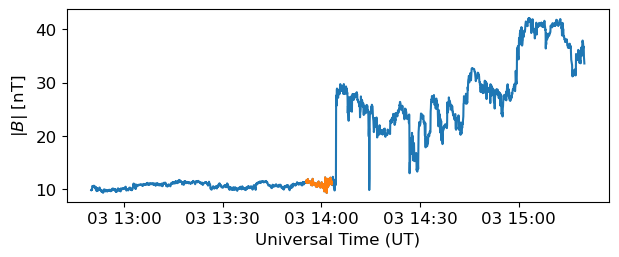

In [25]:
#~~~~~~~~The two below can be edited~~~~#
st_up = start_time_up
en_up = end_time_up
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

Vitsu, Viteu   = SerPyShock.get_time_indices(st_up, en_up, mom_times)
tsv, sVu       = SerPyShock.select_subS(V, mom_times, Vitsu, Viteu, 3)
tsv, srhou     = SerPyShock.select_subS(rho, mom_times, Vitsu, Viteu, 1)
tsv, sBu     = SerPyShock.select_subS(Brs, mom_times, Vitsu, Viteu, 3)
tsv, sTpu     = SerPyShock.select_subS(Tp, mom_times, Vitsu, Viteu, 1)
tsv, sBmu     = SerPyShock.select_subS(Bm, mom_times, Vitsu, Viteu, 1)
tsv, sUmu     = SerPyShock.select_subS(Um, mom_times, Vitsu, Viteu, 1)
tsv, sUnu     = SerPyShock.select_subS(Un, mom_times, Vitsu, Viteu, 1)
tsv, sUn_sfu     = SerPyShock.select_subS(Un_sf, mom_times, Vitsu, Viteu, 1)

# PURPOSE: The orange show the upstream window you are averaging
plt.figure(figsize=[7,2.5])
plt.plot(mom_times, Bm)
plt.plot(tsv, sBmu)
plt.ylabel('$|B|$ [nT]',fontsize=fsax)
plt.xlabel("Universal Time (UT)")

In [26]:
print("Below are your fast magnetosonic, slow magnetosonic and Alfvenic Mach numbers")

Mfms = np.nanmean(np.abs(Un_sf[Vitsu:Viteu])/(Vfms[Vitsu:Viteu]*10**(-3)))
Msms = np.nanmean(np.abs(Un_sf[Vitsu:Viteu])/(Vsms[Vitsu:Viteu]*10**(-3)))
Ma   = np.nanmean(np.abs(Un_sf[Vitsu:Viteu])/(vA[Vitsu:Viteu]*10**(-3)))

betau = np.nanmean(np.abs(beta[Vitsu:Viteu]))
rhou  = np.nanmean(np.abs(rho[Vitsu:Viteu]))

print("M_fms = " + str(Mfms))
print("M_sms = " + str(Msms))
print("M_A = " + str(Ma))

Below are your fast magnetosonic, slow magnetosonic and Alfvenic Mach numbers
M_fms = 4.282869590595427
M_sms = 13.095107103370522
M_A = 4.824563255930563
